# Inflammation scores for OPCs and oligodendrocytes in MERFISH LPS dataset

This notebook contains all code for running inflammation gene signature scores for OPCs and oligodendrocytes in the MERFISH LPS dataset and comparing across conditions.

**Associated manuscript figures/tables:**
- Extended Data Figures: 8b


**Inputs required:**
- `results/clocks/anndata/allen_aging_lps_spatialsmooth_spage.h5ad` - AnnData object with spatial aging clocks predictions for MERFISH LPS dataset (generated from `4A_application_to_interventions.ipynb`)


**Conda environment used**: `requirements/merfish.txt`

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV, lasso_path, LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from scipy.stats import pearsonr, spearmanr
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp
from decimal import Decimal

from clock_preprocessing import *
from clock_prediction import *

In [2]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

## OPC inflammation signature (LPS)

In [3]:
adata = sc.read_h5ad("results/clocks/anndata/allen_aging_lps_spatialsmooth_spage.h5ad")

In [4]:
# get signature

olig_inflammation_genes = ['C4b', 'Il33', 'Il18',
                        'Serpina3n', 'Cdkn1a', 'Tnfrsf12a', 'H2-D1', 'Stat1', 'Ifit1']
intersection_genes = np.intersect1d(olig_inflammation_genes, adata.var_names)

adata = adata[:,intersection_genes].copy()
adata.obs["inflammation_score"] = np.sum(adata.X, axis=1)

In [5]:
# subset old
adata = adata[adata.obs.age==20.93].copy()

# map conditions
condition_dict = {
    "aging":"Control",
    "lps":"LPS"
}

adata.obs["condition"] = [condition_dict[x] for x in adata.obs.cohort]

# map regions
coarse_region_mapping = {
    "corpus callosum":"CC/ACO",
    "olfactory region":"CC/ACO",
    "cortical layer II/III":"CTX",
    "cortical layer V":"CTX",
    "cortical layer VI":"CTX",
    "pia mater":"CTX",
    "striatum":"STR",
    "brain ventricle":"VEN",
}

adata.obs["region_coarse"] = [coarse_region_mapping[x] for x in adata.obs.region]
region_order = ['CTX', 'STR', 'CC/ACO', 'VEN']
adata.obs["region_coarse"] = adata.obs["region_coarse"].astype('category').cat.reorder_categories(region_order)

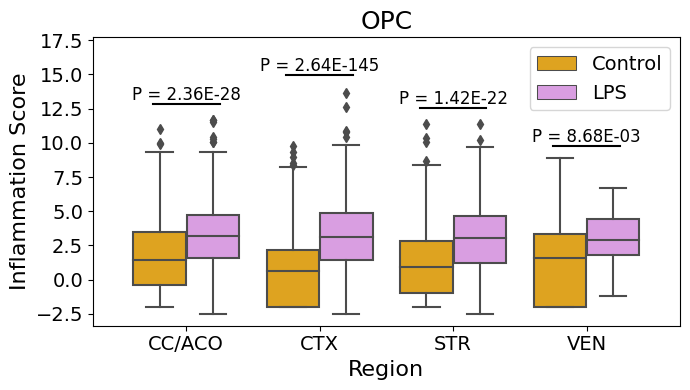

In [6]:
# FINAL FIGURE (BY REGION)

celltype = "OPC"

exp_palette = {
    "Control":"#FEAF00",
    "LPS":"#E193EC"
}

#-----------------------------

sub_adata = adata[adata.obs.celltype==celltype]
x_labels = np.array(sub_adata.obs.region_coarse)
y_values = np.array(sub_adata.obs.inflammation_score)
hue_values = np.array(sub_adata.obs.condition)

fig, ax = plt.subplots(figsize=(7,4))

sns.boxplot(x=x_labels,y=y_values,hue=hue_values,
            palette=exp_palette)

# statistical annotation
x_coords = [0, 1, 2, 3]
y_coords = []
cols = ['k']*len(x_coords)
h = 0
w = 0.25
pval_labels = []
for reg in np.unique(x_labels):
    t,p = mannwhitneyu(y_values[(x_labels==reg)&(hue_values=="Control")],
                       y_values[(x_labels==reg)&(hue_values=="LPS")])
    y_coords.append(1.1*np.max(y_values[(x_labels==reg)]))
    pval_labels.append(p)
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=12)
plt.ylim([None, np.max(y_values)*1.3])

plt.legend(fontsize=14)
plt.title(f"{celltype}", fontsize=18)
plt.ylabel("Inflammation Score", fontsize=16)
plt.xlabel("Region", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f"plots/clocks/allen_lps21_inflammation_score_violin_regioned{celltype}.pdf",
           bbox_inches='tight')
plt.show()

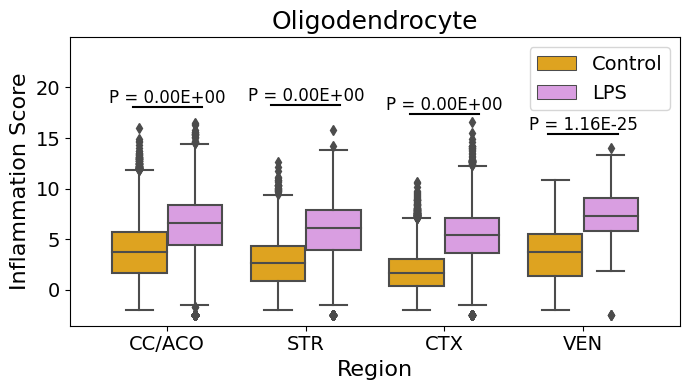

In [7]:
# FINAL FIGURE (BY REGION)

celltype = "Oligodendrocyte"

exp_palette = {
    "Control":"#FEAF00",
    "LPS":"#E193EC"
}

#-----------------------------

sub_adata = adata[adata.obs.celltype==celltype]
x_labels = np.array(sub_adata.obs.region_coarse)
y_values = np.array(sub_adata.obs.inflammation_score)
hue_values = np.array(sub_adata.obs.condition)

fig, ax = plt.subplots(figsize=(7,4))

sns.boxplot(x=x_labels,y=y_values,hue=hue_values,
            palette=exp_palette)

# statistical annotation
x_coords = [0, 1, 2, 3]
y_coords = []
cols = ['k']*len(x_coords)
h = 0
w = 0.25
pval_labels = []
for reg in np.unique(x_labels):
    t,p = mannwhitneyu(y_values[(x_labels==reg)&(hue_values=="Control")],
                       y_values[(x_labels==reg)&(hue_values=="LPS")])
    y_coords.append(1.1*np.max(y_values[(x_labels==reg)]))
    pval_labels.append(p)
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=12)
plt.ylim([None, np.max(y_values)*1.5])

plt.legend(fontsize=14)
plt.title(f"{celltype}", fontsize=18)
plt.ylabel("Inflammation Score", fontsize=16)
plt.xlabel("Region", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f"plots/clocks/allen_lps21_inflammation_score_violin_regioned{celltype}.pdf",
           bbox_inches='tight')
plt.show()